In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.io as pio

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}
pio.renderers.default = "png"
px.defaults.color_discrete_sequence = px.colors.qualitative.D3

In [ ]:
import simbench as sb
sb_scenario = "1-LV-rural1--0-no_sw"
_net_before = sb.get_simbench_net(sb_scenario)

In [5]:
_net_before["line"].head()

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,max_loading_percent,subnet,voltLvl
0,LV1.101 Line 1,NAYY 4x150SE 0.6/1kV,9,2,0.055767,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,100.0,LV1.101,7
1,LV1.101 Line 2,NAYY 4x150SE 0.6/1kV,13,11,0.053576,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,100.0,LV1.101,7
2,LV1.101 Line 3,NAYY 4x150SE 0.6/1kV,6,3,0.049814,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,100.0,LV1.101,7
3,LV1.101 Line 4,NAYY 4x150SE 0.6/1kV,8,1,0.017886,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,100.0,LV1.101,7
4,LV1.101 Line 5,NAYY 4x150SE 0.6/1kV,7,10,0.016089,0.2067,0.080425,829.999394,0.0,0.27,1.0,1,cs,True,100.0,LV1.101,7


In [6]:
import scenario

# Network, active profiles, reactive profiles, active net loads, battery specs
net, dfp, dfq, df, batteries = scenario.get_network_and_timeseries()

Max loading = 114.908
Transformator eq. impedance (secondary) = (0.015+0.037j) Ohm (x1).


In [9]:
df.sum(axis=1).min()

-49.06864409910382

![./results/SimBench grid with text.png](results/SimBench%20grid%20with%20text.png)

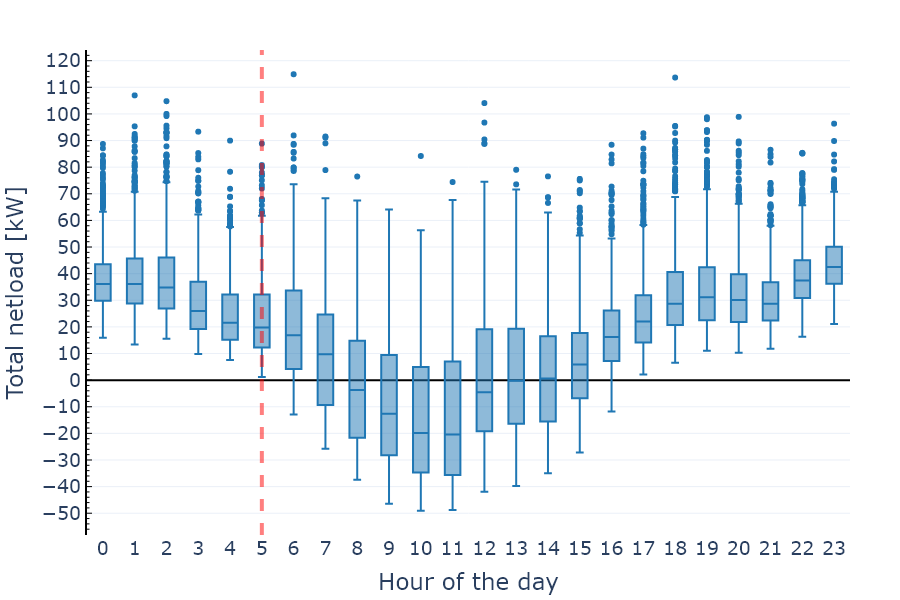

In [3]:
# Box plot of the netload data
graph = df.sum(axis=1).copy().to_frame("netload")
graph["hour"] = graph.index.hour

fig = px.box(graph, y="netload", x="hour")
fig.add_vline(x=5, line_color="red", line_dash="dash", line_width=4, opacity=0.5)
fig.update_layout(layout, xaxis_dtick=1, height=600, width=900)
fig.update_layout(xaxis_title="Hour of the day", yaxis_title="Total netload [kW]")
fig.update_layout(yaxis_dtick=10, yaxis_minor_ticks="inside", yaxis_minor_ticklen=2.5, xaxis_zeroline=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(ticklen=5, tickcolor='black', ticks="inside")
fig.show()

In [3]:
import cost
import losses
import time

def compare_cost_vs_losses(is_winter, nb_hours=48):
    p_kw = scenario.get_day_from_consumption_level(df, highest_consumption=is_winter, hours=5, minutes=0, nb_hours=nb_hours)
    q_kvar = dfq.loc[p_kw.index[0]:p_kw.index[-1], :].copy()
    start_clock = time.time()

    cost_model = cost.OptimizeCost()
    cost_model.solve(p_kw, {i: dict(batteries) for i in df.columns})
    score = cost.Score(net)
    score.score(p_kw, q_kvar, cost_model.schedules["schedules"])
    cost_model.score = score

    loss_model = losses.OptimizeLosses()
    loss_model.remove_battery_efficiency = not is_winter
    loss_model.solve(net, p_kw, q_kvar, {i: dict(batteries) for i in df.columns})

    target_cost = 1.0025 * cost_model.actual_cost
    tradeoff_model = losses.OptimizeLosses()
    tradeoff_model.remove_battery_efficiency = not is_winter
    tradeoff_model.solve(net, p_kw, q_kvar, {i: dict(batteries) for i in df.columns}, target_cost, cost_model.actual_cost)
    print(f"Elapsed time {round(time.time() - start_clock, 1)} seconds")
    return cost_model, loss_model, tradeoff_model

def plot_cost_vs_losses(cost_model, loss_model, tradeoff_model, x_annotation=(48, 50, 48), is_winter=True):
    graph = cost_model.input_p_kw.sum(axis=1).to_frame("Netload")
    graph["cost_model"] = cost_model.schedules["battery_energy"].sum(axis=1)
    graph["loss_model"] = loss_model.schedules["battery_energy"].sum(axis=1)
    graph["tradeoff_model"] = tradeoff_model.schedules["battery_energy"].sum(axis=1)

    fig = px.line(graph)
    fig.data[0].update(line_width=1, line_color="black")
    fig.data[1].update(line_width=5, opacity=0.7)
    fig.data[2].update(line_width=5, opacity=0.7, fill="tonexty", fillcolor="rgba(44, 160, 44, 0.01)")
    fig.data[3].update(line_dash="dot")

    fig.update_layout(layout, width=1000, height=700, legend_orientation="h", title= "Winter" if is_winter else "Summer")
    fig.update_layout(yaxis_title="SOC [kWh]", xaxis_title="", legend_title="")
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=10)

    fig.add_annotation(text=f"{round(cost_model.actual_cost, 1)}€ | {round(cost_model.score.total_losses, 2)}kWh "
                            f"| {round(cost_model.score.max_upper_demand, 1) if is_winter else round(cost_model.score.max_back_feed, 1)}kW "
                            f"| {round(cost_model.score.vm_below_percent, 1) if is_winter else round(cost_model.score.vm_above_percent, 1)}%",
                       x=fig.data[1].x[x_annotation[0]],
                       y=fig.data[1].y[x_annotation[0]], font_color="black", font_family="Arial Black")
    fig.add_annotation(text=f"{round(tradeoff_model.actual_cost, 1)}€ | {round(tradeoff_model.total_losses, 2)}kWh"
                            f"| {round(tradeoff_model.max_upper_demand, 1) if is_winter else round(tradeoff_model.max_back_feed, 1)}kW "
                            f"| {round(tradeoff_model.vm_below_percent, 1) if is_winter else round(tradeoff_model.vm_above_percent, 1)}%",
                       x=fig.data[3].x[x_annotation[1]],
                       y=fig.data[3].y[x_annotation[1]], font_color="black", font_family="Arial Black")
    fig.add_annotation(text=f"{round(loss_model.actual_cost, 1)}€ | {round(loss_model.total_losses, 2)}kWh "
                            f"| {round(loss_model.max_upper_demand, 1) if is_winter else round(loss_model.max_back_feed, 1)}kW "
                            f"| {round(loss_model.vm_below_percent, 1) if is_winter else round(loss_model.vm_above_percent, 1)}%",
                       x=fig.data[2].x[x_annotation[2]],
                       y=fig.data[2].y[x_annotation[2]], font_color="black", font_family="Arial Black")
    fig.add_hline(y=26*batteries["max_kwh"]*(1-batteries["offset"]),
                  line_color="rgba(214, 39, 40, 0.8)", line_dash="dash", annotation_text="Full battery capacity",
                  annotation_font_color="rgba(214, 39, 40, 0.8)")
    fig.show()

Elapsed time 18.6 seconds


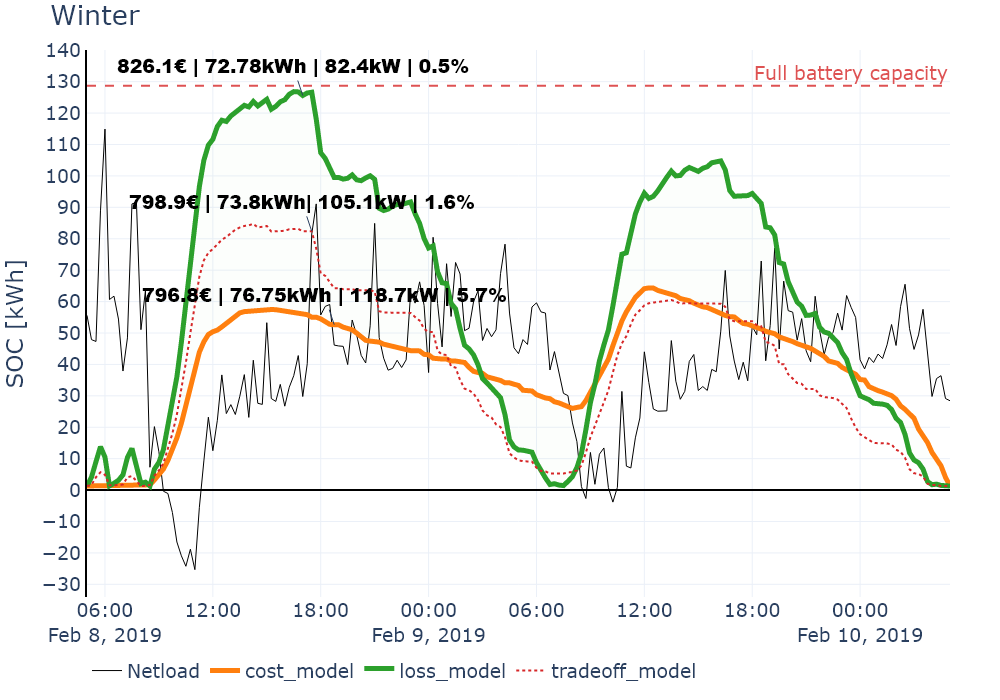

In [25]:
cost_model, loss_model, tradeoff_model = compare_cost_vs_losses(is_winter=True)
plot_cost_vs_losses(cost_model, loss_model, tradeoff_model, x_annotation=(55, 50, 48), is_winter=True)

Elapsed time 17.1 seconds


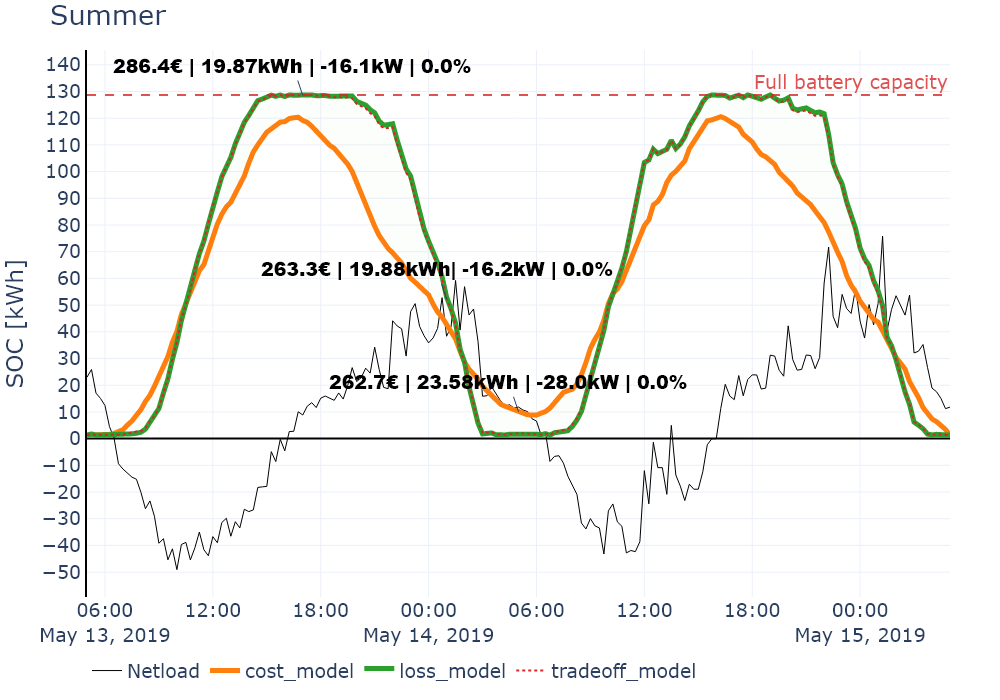

In [26]:
cost_model, loss_model, tradeoff_model = compare_cost_vs_losses(is_winter=False)
plot_cost_vs_losses(cost_model, loss_model, tradeoff_model, x_annotation=(96, 80, 48), is_winter=False)

In [54]:
def compare_ind_vs_col(is_winter):
    p_kw = scenario.get_day_from_consumption_level(df, highest_consumption=is_winter, hours=5, minutes=0, nb_hours=48)
    q_kvar = dfq.loc[p_kw.index[0]:p_kw.index[-1], :].copy()
    start_clock = time.time()

    individual = cost.OptimizeCost()
    individual.solve(p_kw, {i: dict(batteries) for i in df.columns})
    score = cost.Score(net)
    score.score(p_kw, q_kvar, individual.schedules["schedules"])
    individual.score = score

    collective = cost.OptimizeCost()
    collective.solve_community_problem = True
    collective.solve(p_kw, {i: dict(batteries) for i in df.columns})
    score = cost.Score(net)
    score.solve_with_community_cost = True
    score.score(p_kw, q_kvar, collective.schedules["schedules"])
    collective.score = score

    target_cost = 1.0025 * individual.actual_cost
    indi_tradeoff = losses.OptimizeLosses()
    indi_tradeoff.remove_battery_efficiency = not is_winter
    indi_tradeoff.solve(net, p_kw, q_kvar, {i: dict(batteries) for i in df.columns}, target_cost, individual.actual_cost)

    target_cost = 1.0025 * collective.actual_cost
    coll_tradeoff = losses.OptimizeLosses()
    coll_tradeoff.solve_with_community_cost = True
    coll_tradeoff.remove_battery_efficiency = not is_winter
    coll_tradeoff.solve(net, p_kw, q_kvar, {i: dict(batteries) for i in df.columns}, target_cost, collective.actual_cost)

    print(f"Elapsed time {round(time.time() - start_clock, 1)} seconds")
    return individual, collective, indi_tradeoff, coll_tradeoff

def plot_ind_vs_col(individual, collective, indi_tradeoff, coll_tradeoff, x_annotation=(48, 50, 48), is_winter=True):
    graph = individual.input_p_kw.sum(axis=1).to_frame("Netload")
    graph["individual"] = individual.schedules["battery_energy"].sum(axis=1)
    graph["collective"] = collective.schedules["battery_energy"].sum(axis=1)
    graph["indi_tradeoff"] = indi_tradeoff.schedules["battery_energy"].sum(axis=1)
    graph["coll_tradeoff"] = coll_tradeoff.schedules["battery_energy"].sum(axis=1)
    graph.drop(columns=["Netload"], inplace=True)

    fig = px.line(graph)
    fig.data[0].update(line_width=5, opacity=0.7, line_color="rgba(55, 128, 191, 1.0)")
    fig.data[1].update(line_width=3, opacity=0.7, line_color="rgba(255, 127, 14, 1.0)")
    fig.data[2].update(line_width=5, opacity=0.7, line_dash="dot", line_color="rgba(55, 128, 191, 1.0)")
    fig.data[3].update(line_width=3, opacity=0.7, line_dash="dot", line_color="rgba(255, 127, 14, 1.0)")

    fig.update_layout(layout, width=1000, height=700, legend_orientation="h", title= "Winter" if is_winter else "Summer")
    fig.update_layout(yaxis_title="SOC [kWh]", xaxis_title="", legend_title="")
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=10)

    color = ["rgba(55, 128, 191, 1.0)", "rgba(255, 127, 14, 1.0)", "rgba(55, 128, 191, 1.0)", "rgba(255, 127, 14, 1.0)"]
    for i, _ in enumerate([individual, collective]):
        fig.add_annotation(text=f"{round(_.actual_cost, 1)}€ | {round(_.score.total_losses, 2)}kWh "
                                f"| {round(_.score.max_upper_demand, 1) if is_winter else round(_.score.max_back_feed, 1)}kW "
                                f"| {round(_.score.vm_below_percent, 1) if is_winter else round(_.score.vm_above_percent, 1)}%",
                           x=fig.data[i].x[x_annotation[i]],
                           y=fig.data[i].y[x_annotation[i]], font_color=color[i], font_family="Arial Black")

    for i, _ in enumerate([indi_tradeoff, coll_tradeoff]):
        i += 2
        fig.add_annotation(text=f"{round(_.actual_cost, 1)}€ | {round(_.total_losses, 2)}kWh "
                                f"| {round(_.max_upper_demand, 1) if is_winter else round(_.max_back_feed, 1)}kW "
                                f"| {round(_.vm_below_percent, 1) if is_winter else round(_.vm_above_percent, 1)}%",
                           x=fig.data[i].x[x_annotation[i]],
                           y=fig.data[i].y[x_annotation[i]], font_color=color[i], font_family="Arial Black")

    fig.add_hline(y=26*batteries["max_kwh"]*(1-batteries["offset"]),
                  line_color="rgba(214, 39, 40, 0.8)", line_dash="dash", annotation_text="Full battery capacity",
                  annotation_font_color="rgba(214, 39, 40, 0.8)")
    fig.show()

Elapsed time 22.5 seconds


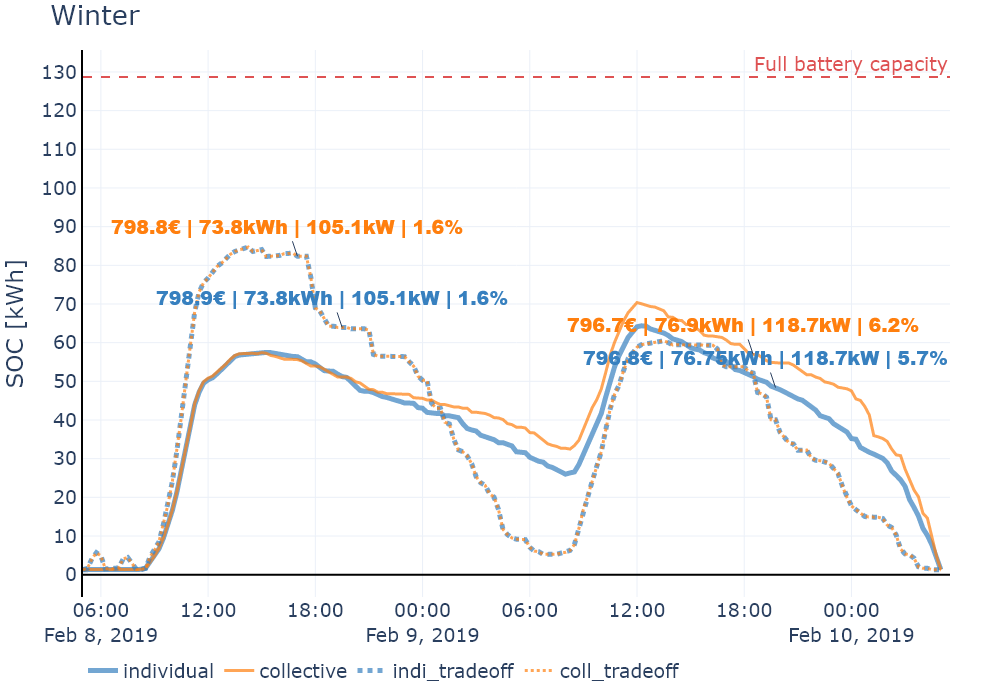

In [60]:
individual, collective, indi_tradeoff, coll_tradeoff = compare_ind_vs_col(is_winter=True)
plot_ind_vs_col(individual, collective, indi_tradeoff, coll_tradeoff, x_annotation=(155, 150, 58, 48), is_winter=True)

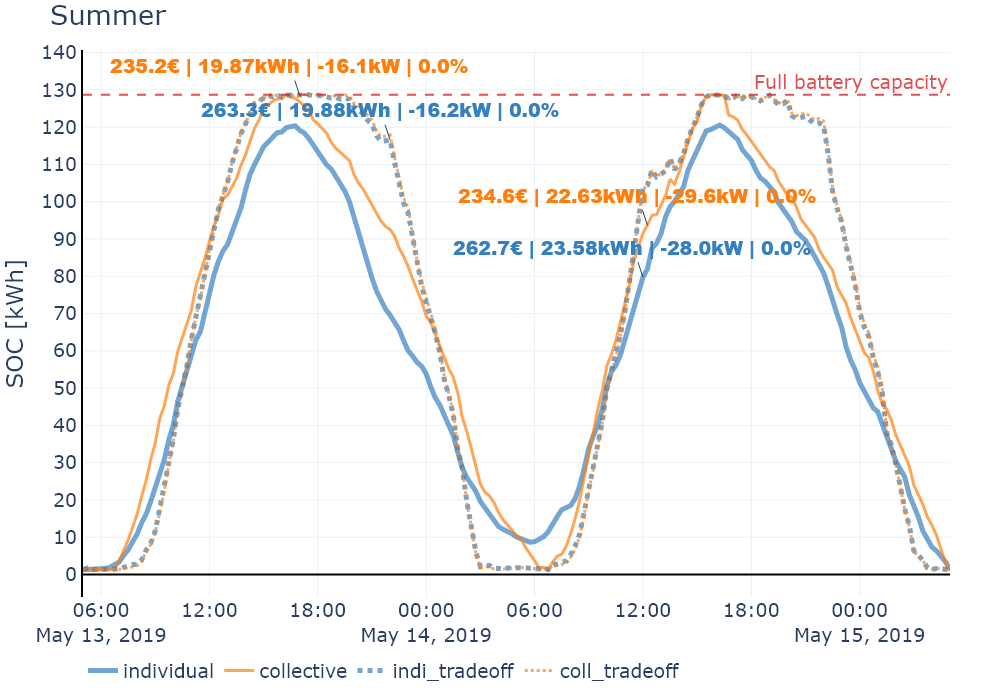

In [59]:
individual, collective, indi_tradeoff, coll_tradeoff = compare_ind_vs_col(is_winter=False)
plot_ind_vs_col(individual, collective, indi_tradeoff, coll_tradeoff, x_annotation=(124, 125, 68, 48), is_winter=False)

In [4]:
time_it_takes = []
nb_days = [day + 1 for day in range(7)]
for day in nb_days:
    print(f"nb_days={day}", end="\r")
    start_clock = time.time()
    compare_cost_vs_losses(is_winter=True, nb_hours=day*24)
    time_it_takes.append(round(time.time() - start_clock, 1))

Elapsed time 14.0 seconds
Elapsed time 17.6 seconds
Elapsed time 27.1 seconds
Elapsed time 35.7 seconds
Elapsed time 42.4 seconds
Elapsed time 53.3 seconds
Elapsed time 59.1 seconds


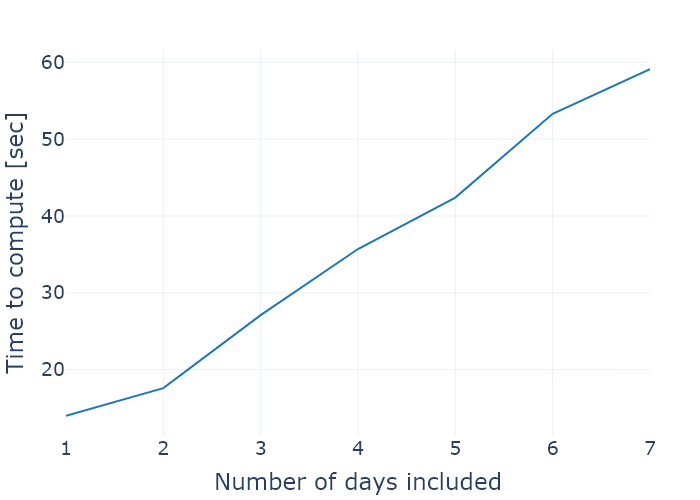

In [5]:
graph = pd.Series(index=nb_days, data=time_it_takes)
fig = px.line(graph)
fig.update_layout(layout, yaxis_title="Time to compute [sec]")
fig.update_layout(showlegend=False, xaxis_title="Number of days included")
fig.show()

This might increase the number of day considered as breaking complementary constraints if doing 7 days at once.